1. Необходимо скачать и подготовить датасет
https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks
для обучения модели на сегментацию губ (обратите внимание, что сегментация
подразумевает уже два класса: фон и губы).
2. И затем обучить Модель на выбор из segmentation_models_pytorch
3. *(Усложненное задание) Переделайте архитектуру декодера Unet так, как в этой
работе https://www.ics.uci.edu/~haoyum3/papers/slides_icivc.pdf. Эта тема
пересекается с темой о второго вебинара о LSTM-сетях. И попробуйте обучить
получившуюся нейронную сеть

In [1]:
import os
import time
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import torch
from torch import nn, optim
import segmentation_models_pytorch as smp

In [29]:
import segmentation_models_pytorch.utils.metrics as smp_metrics
import segmentation_models_pytorch.utils.losses as smp_losses

In [2]:
PATH = Path('set-lipstick-original')
IMAGES = '720p'
MASKS = 'mask'
LIST_CSV = 'list.csv'

In [3]:
DATA_PATH = PATH.joinpath(IMAGES)
MASKS_PATH = PATH.joinpath(MASKS)
LIST_PATH = PATH.joinpath(LIST_CSV)

In [4]:
df = pd.read_csv(LIST_PATH)
df = df[['filename', 'mask']]

In [5]:
list_of_images = [i for i in Path(DATA_PATH).iterdir()]
list_of_masks = [i for i in Path(MASKS_PATH).iterdir()]

In [6]:
df = df.loc[df['mask'].isin([i.name for i in list_of_masks])]

In [7]:
def image_resize(image_name, mask_name, new_size):
    image = cv2.imread(str(Path(DATA_PATH.joinpath(image_name))))
    mask = cv2.imread(str(Path(MASKS_PATH.joinpath(mask_name))))    
    
    resized_image = cv2.cvtColor(cv2.resize(image, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    resized_mask = cv2.cvtColor(cv2.resize(mask, (new_size, new_size)), cv2.COLOR_BGR2RGB)    
    return resized_image, resized_mask

In [8]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data, preprocessing=None):
        self.data = data
        self.preprocessing = preprocessing
        
        self.images_paths = self.data.iloc[:,0]
        self.masks_paths = self.data.iloc[:,1]
        
        self.data_len = len(self.data.index)
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, index):
        img_path = self.images_paths[index]
        mask_path = self.masks_paths[index]
        
        img, mask = image_resize(img_path, mask_path, 256)
        
        img = img.astype(float)
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img)
            img /= 255.
            
        img = img.permute(2, 0, 1)
        
        cls_mask_1 = mask[..., 1]
        cls_mask_1 = np.where(mask>50, 1, 0)[:,:,1]
        cls_mask_1 = cls_mask_1.astype('float')
        
        masks = [cls_mask_1]
        masks = torch.as_tensor(masks, dtype=torch.float)
        
        return img.float(), masks

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [10]:
import getpass

password = getpass.getpass()
command = "sudo -S jupyter nbextension enable --py --sys-prefix widgetsnbextension"
os.system('echo %s | %s' % (password, command))

········


[sudo] password for boormistr: Sorry, try again.
[sudo] password for boormistr: 
sudo: no password was provided
sudo: 1 incorrect password attempt


256

In [10]:
segmodel = smp.Unet(encoder_name='resnet50', classes=1, activation='sigmoid')
segmodel.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/boormistr/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [11]:
preprocess_input = smp.encoders.get_preprocessing_fn(encoder_name='resnet50',
                                                     pretrained='imagenet')

In [12]:
x_train, x_valid = train_test_split(df, test_size=0.3, random_state=42)
x_train.reset_index(drop=True, inplace=True)
x_valid.reset_index(drop=True, inplace=True)

train_data = MyDataset(x_train, preprocessing=preprocess_input)
valid_data = MyDataset(x_valid, preprocessing=preprocess_input)

In [13]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=4, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 256, 256])
tensor(0.) tensor(1.)


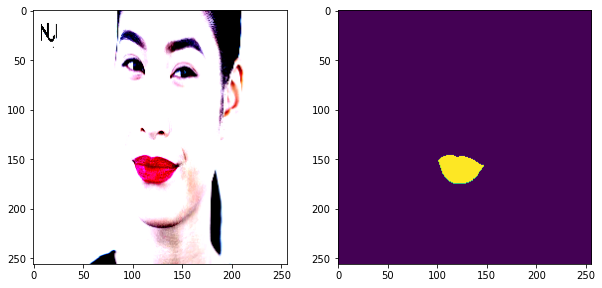

In [18]:
for imgs, masks in train_loader:
    print(imgs.shape)
    print(masks.shape)
    print(masks.min(), masks.max())
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(imgs[0].permute(1, 2, 0))
    ax[1].imshow(masks[0].permute(1, 2, 0))    
    break

In [31]:
criterion = smp_losses.DiceLoss()
metrics = [smp_metrics.IoU(),]
optimizer = optim.Adam(segmodel.parameters(), lr=0.01)

In [33]:
train_epoch = smp.utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True
)

valid_epoch = smp.utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics,
    device=device,
    verbose=True
)

In [34]:
# train model
max_score = 0

for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
#     if max_score < valid_logs['iou_score']:
#         max_score = valid_logs['iou_score']
#         torch.save(segmodel, './best_model.pth')
#         print('Model saved!')

Epoch: 1
train: 100%|█| 1249/1249 [2:03:58<00:00,  5.96s/it, dice_loss - 0.1894, iou_scor
valid: 100%|█| 2141/2141 [16:42<00:00,  2.14it/s, dice_loss - 0.07817, iou_score


In [37]:
data_iter = iter(train_loader)

In [46]:
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

outputs = segmodel(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

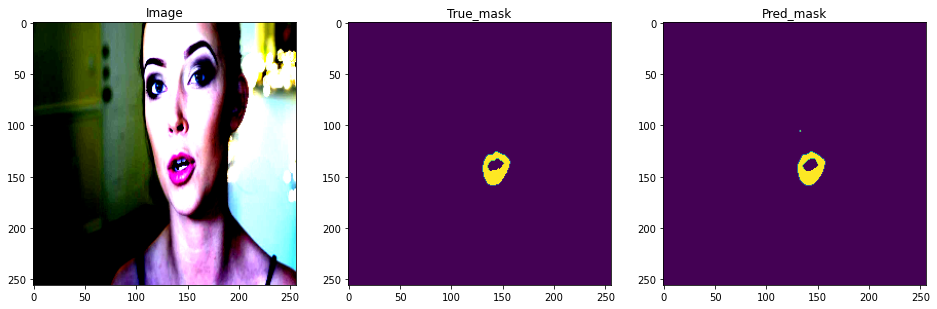

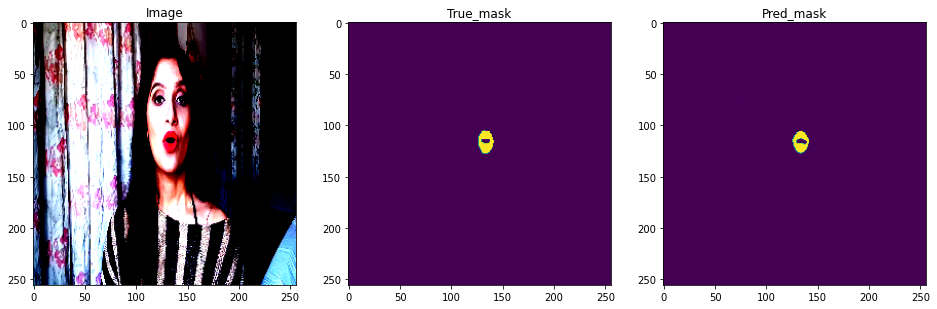

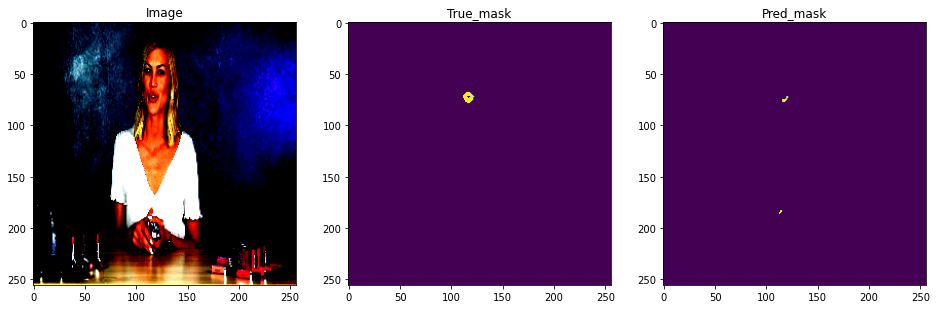

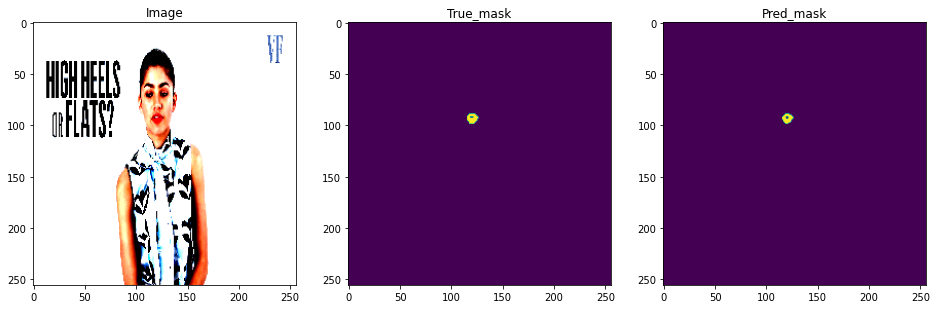

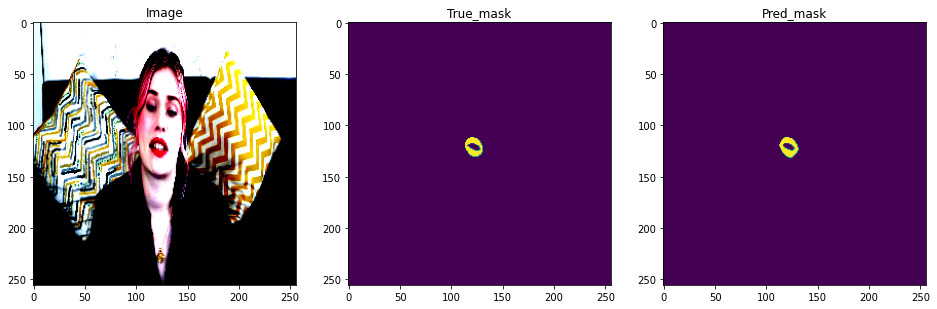

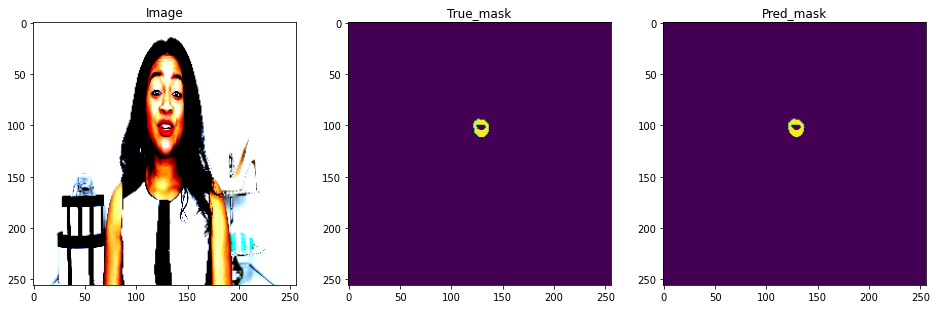

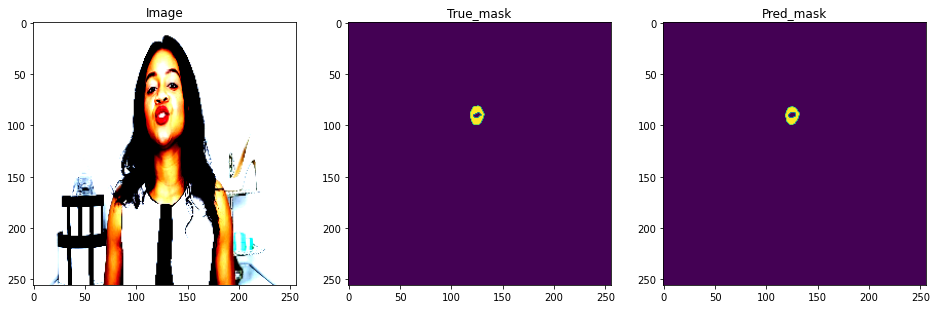

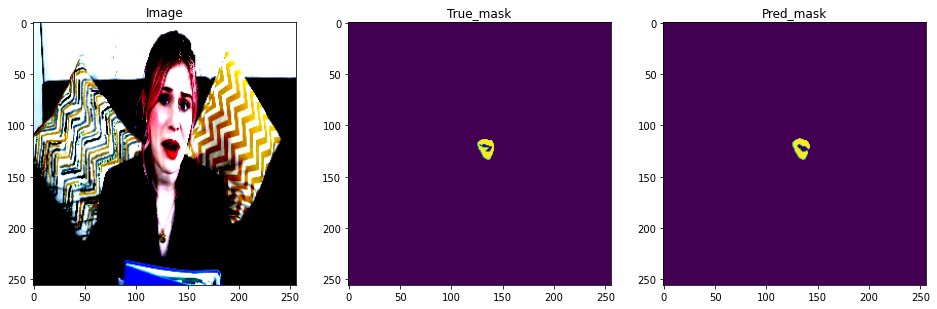

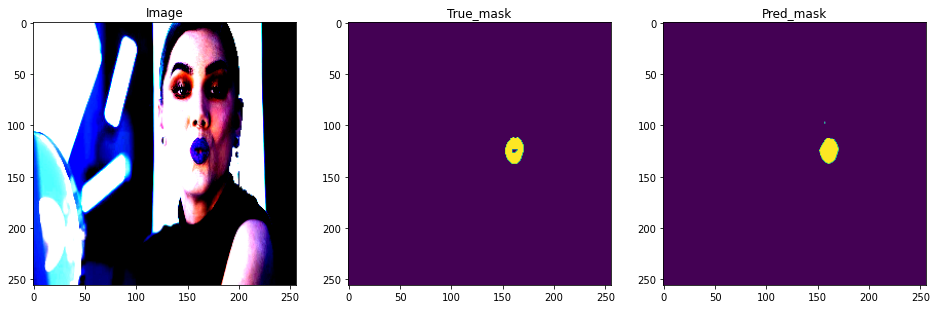

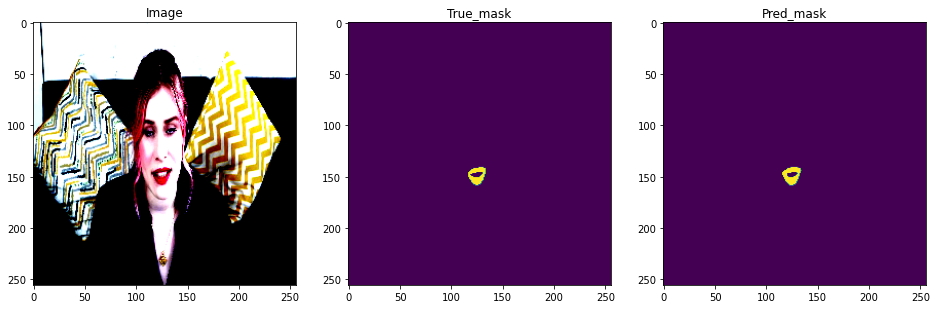

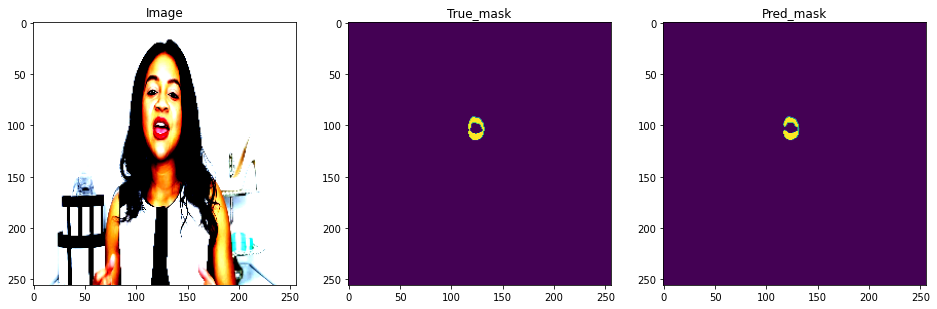

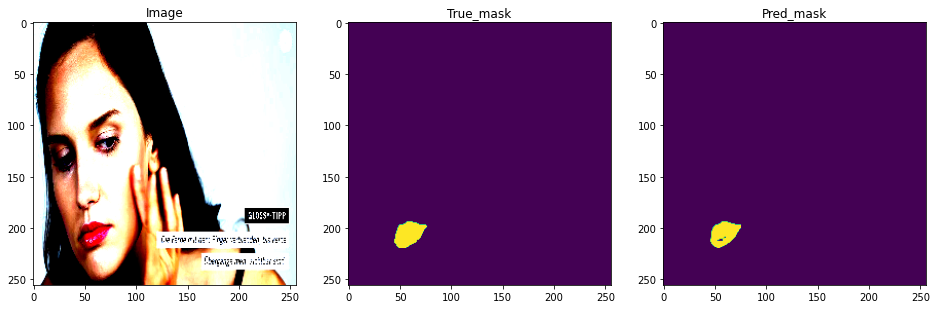

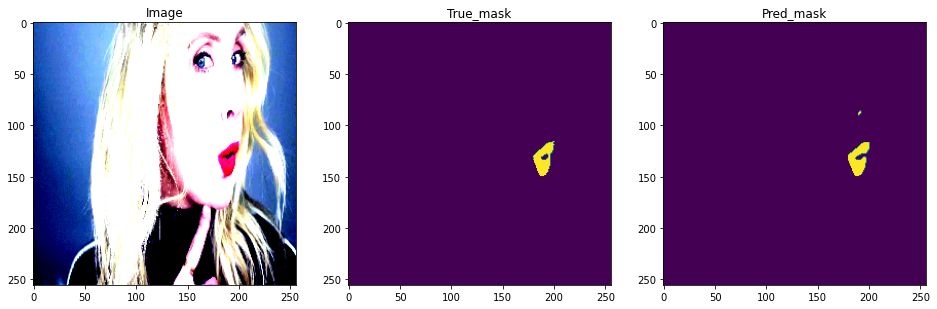

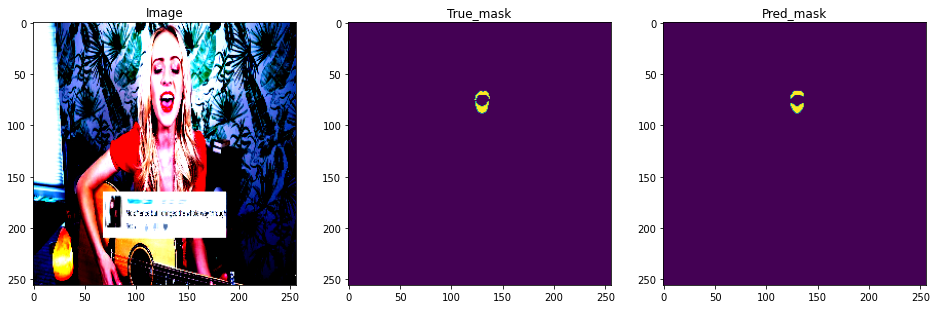

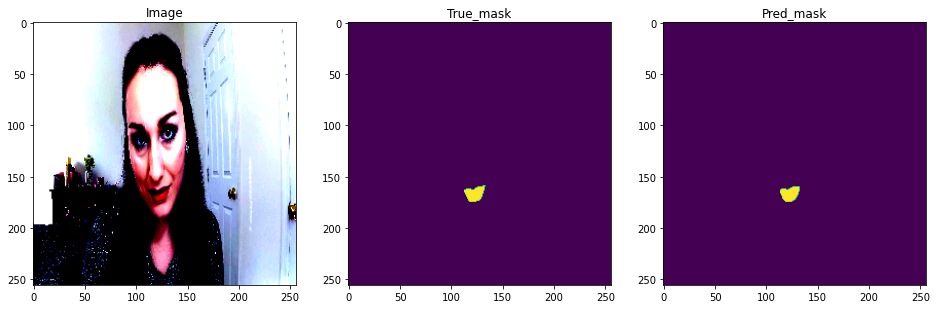

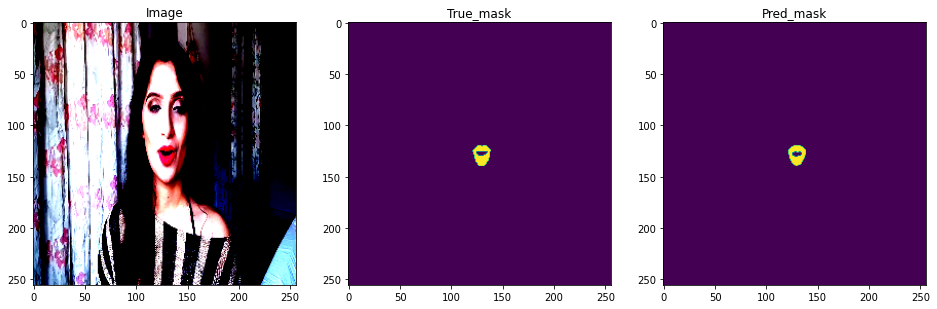

In [47]:
for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0))
    ax_2.set_title('True_mask')
    
    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0))
    ax_3.set_title('Pred_mask')